In [62]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import datetime
import csv
import math
import time
from ProgressBar import ProgressBar

import nltk
import string
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import Lasso

In [22]:
all_data_list = []
for year in range(1997,2007):
    data = pd.read_csv('{}_Output.csv'.format(year), header=None)
    all_data_list.append(data) # list of dataframes
data = pd.concat(all_data_list, axis=0)
data.columns = ['id','date','headline', 'lead']

In [23]:
data['yearmonth'] = map(lambda x: x[:7], data.date)

In [24]:
def getStems(lead):
    stemmer = nltk.stem.SnowballStemmer("english")
    tokens = nltk.word_tokenize(''.join(ch for ch in lead if ch not in set(string.punctuation)))
    return map(lambda x: stemmer.stem(x.decode('utf-8')), tokens)

In [25]:
def joinstems(stemlist):
    return ' '.join(stem for stem in stemlist)

In [26]:
stems = map(getStems, data.lead)

In [27]:
data['leadstems'] = map(joinstems, stems)

In [28]:
countVec = CountVectorizer(stop_words='english', max_df=0.8, min_df=.005, strip_accents='unicode')
wordMatrix = countVec.fit_transform(data.leadstems)

In [29]:
unigramVocab = countVec.get_feature_names()

In [282]:
num_topics=8
lda = LatentDirichletAllocation(n_topics=num_topics)

In [283]:
ldaDocs = lda.fit_transform(wordMatrix)

In [33]:
lda.components_.shape

(10, 1404)

In [284]:
num_top_words = 10
topic_words = []

for topic in lda.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([unigramVocab[i] for i in word_idx])

In [285]:
topicDF = pd.DataFrame(topic_words)
topicDF.index = ['Topic {}'.format(i) for i in range(1,(num_topics+1))]
topicDF.columns = ['Stem {}'.format(i) for i in range(1,(num_top_words+1))]
topicDF

,Stem 1,Stem 2,Stem 3,Stem 4,Stem 5,Stem 6,Stem 7,Stem 8,Stem 9,Stem 10
Topic 1,compani,million,said,offer,base,servic,buy,yesterday,corpor,agre
Topic 2,share,percent,million,said,year,compani,sale,cent,billion,quarter
Topic 3,year,time,like,new,peopl,busi,say,mani,news,just
Topic 4,said,compani,unit,billion,bank,state,cut,plan,year,oil
Topic 5,said,feder,court,state,compani,commiss,euro,secur,trade,new
Topic 6,stock,percent,market,price,fund,investor,rate,report,year,month
Topic 7,execut,chief,new,compani,mr,group,said,offic,york,account
Topic 8,bond,rate,ago,percent,buyer,10yr,telephon,tbill,sourc,500


## Group by month

In [245]:
grouped = data.groupby('yearmonth')

In [246]:
topicsByMonth = np.zeros((len(grouped.groups.keys()),ldaDocs.shape[1]))
for i, month in enumerate(np.sort(grouped.groups.keys())):
    topicsByMonth[i] = np.mean(ldaDocs[grouped.get_group(month).index], axis=0)

In [247]:
topicsByMonth.shape

(120, 5)

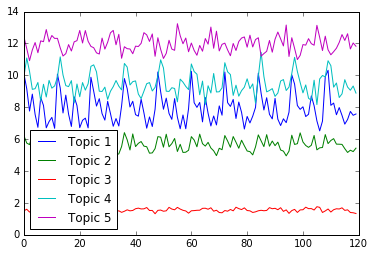

In [248]:
for topic in range(topicsByMonth.shape[1]):
    plt.plot(topicsByMonth[:,topic], label='Topic {}'.format(topic+1))
plt.legend(loc='best')

In [249]:
topicsYearlyDiff = topicsByMonth[12:,:] - topicsByMonth[:-12,:]

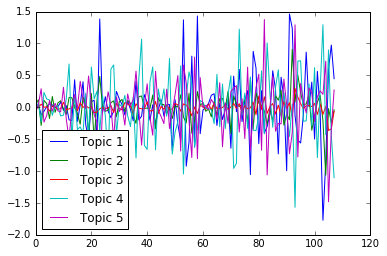

In [250]:
for topic in range(topicsYearlyDiff.shape[1]):
    plt.plot(topicsYearlyDiff[:,topic], label='Topic {}'.format(topic+1))
plt.legend(loc='best')

## CCI

In [251]:
CCI = pd.read_csv('CCI.csv')[['TIME','Value']]
CCI.set_index('TIME', inplace=True)
CCI.head()

,Value
TIME,
1960-01,101.5840
1960-02,101.3255
1960-03,101.1023
1960-04,100.9791
1960-05,101.0102


In [252]:
CCIlimited = CCI.iloc[np.where(CCI.index=='1997-01')[0][0]:(np.where(CCI.index=='2006-12')[0]+1)[0]]

In [253]:
CCIlimited.shape

(120, 1)

## Assembling predictors

In [93]:
X = topicsByMonth

In [254]:
X = topicsYearlyDiff

In [255]:
X = np.hstack((topicsYearlyDiff[2:,:],topicsYearlyDiff[1:-1,:],topicsYearlyDiff[:-2,:]))

In [256]:
X.shape

(106, 15)

In [257]:
y = CCIlimited.Value.values[14:] - CCIlimited.Value.values[13:-1]

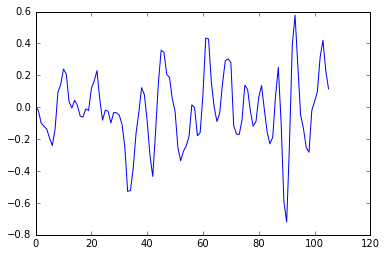

In [258]:
plt.plot(y)

In [267]:
lasso = Lasso(alpha=.005)

In [268]:
lasso.fit(X[:-10,:],y[:-10])
pred = lasso.predict(X[-10:,:])
lasso.score(X[-10:,:],y[-10:])

-0.2556732751978561

In [269]:
X[-10:,:].shape

(10, 15)

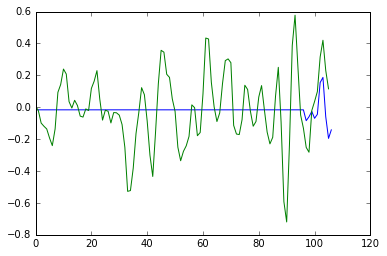

In [270]:
plt.plot(np.concatenate((np.mean(y)*np.ones(97),pred)))
plt.plot(y)

In [271]:
lasso.fit(X[:-10,:],y[:-10])
pred = lasso.predict(X)
lasso.score(X[-10:,:],y[-10:])

-0.2556732751978561

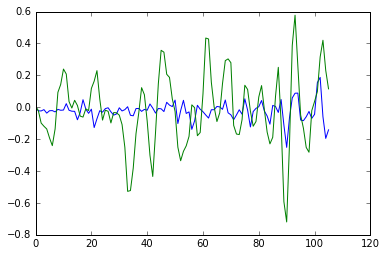

In [272]:
plt.plot(pred)
plt.plot(y)

In [273]:
Xdiff = topicsYearlyDiff[1:,:] - topicsYearlyDiff[:-1,:]

In [274]:
Xdiff.shape

(107, 5)

In [275]:
y = CCIlimited.Value.values[13:] - CCIlimited.Value.values[12:-1]

In [276]:
y.shape

(107,)

In [277]:
lasso = Lasso(alpha=.0001)

In [278]:
lasso.fit(Xdiff[:-10,:],y[:-10])
pred = lasso.predict(Xdiff[-10:,:])
lasso.score(Xdiff[-10:,:],y[-10:])

-0.23037201746794356

In [279]:
lasso.fit(Xdiff[:-10,:],y[:-10])
pred = lasso.predict(Xdiff)
lasso.score(Xdiff[-10:,:],y[-10:])

-0.23037201746794356

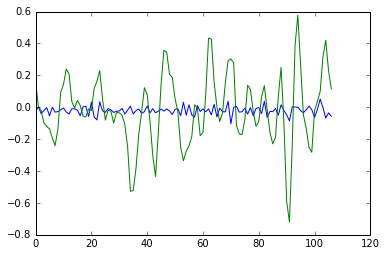

In [280]:
plt.plot(pred)
plt.plot(y)

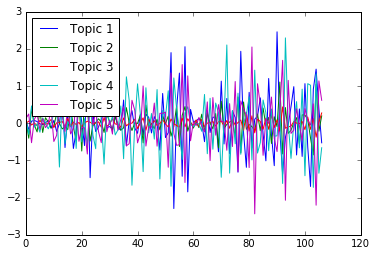

In [281]:
for topic in range(Xdiff.shape[1]):
    plt.plot(Xdiff[:,topic], label='Topic {}'.format(topic+1))
plt.legend(loc='best')